In [1]:
%load_ext autoreload
%autoreload 2

# MAR experiments

In [1]:
import pandas as pd

data = pd.read_excel(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
)
# rename
data.rename({
    c: 'Z_{}'.format(i) for c, i in zip(data.columns, range(len(data.columns)))
}, axis=1, inplace=True)

# normalize
for c in data.columns:
    data[c] = (data[c] - data[c].min()) / (data[c].max() - data[c].min())
data = data.round(4)

In [2]:
data.to_csv('normalized_data.csv', index=False)

In [ ]:
gdf = '# nodes\n'
for c in data.columns:
    gdf += '{}: data(./normalized_data.csv)\n'.format(c)
with open('gdf_Z.yml', 'w') as file:
    file.write(gdf)

In [37]:
from parcs.helpers.missing_data import R_adj_matrix, indicator_graph_description_file, m_graph_convert
from parcs.graph_builder.randomizer import ConnectRandomizer
from parcs.cdag.graph_objects import Graph
import random as rand
import numpy as np
import pandas as pd

# 0. configs
data = pd.read_csv('normalized_data.csv')
N = 500  # number of samples
N_total = len(data.columns) # number of total variables
N_O = 4  # number of fully observed variables
miss_ratio = 0.5  # missing ratio in total

def get_miss_dataset(density_R=None, linear=True):
    # 2. fully and partially observed variables
    obs_v = rand.sample(['Z_{}'.format(i) for i in range(N_total)], N_O)
    miss_v = list(set(data.columns) - set(obs_v))
    total_v = sorted(obs_v + miss_v)
    # 3. write GDF for R
    r_mask = R_adj_matrix(size=N_total-N_O, density=density_R)
    indicator_graph_description_file(
        adj_matrix=r_mask,
        node_names=miss_v,
        prefix='R',
        miss_ratio=miss_ratio,
        supress_asteriks=False,
        subscript_only=True,
        file_dir='./gdf_R.yml'
    )
    # 4. randomize
    if linear:
        guideline = 'guideline.yml'
    else:
        guideline = 'guideline_nonlinear.yml'
    rndz = ConnectRandomizer(
    parent_graph_dir='gdf_Z.yml',
    child_graph_dir='gdf_R.yml',
    guideline_dir=guideline,
    adj_matrix_mask=pd.DataFrame(np.ones(shape=(N_total, N_total-N_O)),
                                 index=data.columns,
                                 columns=['R_{}'.format(i.split('_')[1]) for i in miss_v])
    )
    # 5. samples
    nodes, edges = rndz.get_graph_params()
    g = Graph(nodes=nodes, edges=edges)
    s = g.sample(N)

    # outputs
    gt = s[total_v]
    ds = m_graph_convert(s, missingness_prefix='R_', shared_subscript=True)
    return gt, ds[total_v]

In [38]:
def RMSE(gt, ds, mask):
    se = np.square(
        gt[mask] - ds[mask]
    )
    mse = se.sum()/n
    return np.sqrt(mse)

## linear vs. nonlinear

In [56]:
import json
from hyperimpute.plugins.imputers import Imputers
import warnings
warnings.filterwarnings("ignore")

iters = 20

In [57]:
# linear
np.random.seed(2022)
rmse_hi = []
rmse_mf = []
for it in range(iters):
    print(it)
    gt, ds = get_miss_dataset(density_R=0, linear=True)
    mask = ds.isna().values
    mf = Imputers().get('missforest')
    hi = Imputers().get('hyperimpute')
    imp_hi = hi.fit_transform(ds)
    imp_mf = mf.fit_transform(ds)
    rmse_hi.append(RMSE(gt.values, imp_hi.values, mask))
    rmse_mf.append(RMSE(gt.values, imp_mf.values, mask))

results = {'hyperimpute': rmse_hi, 'missforest': rmse_mf}

with open('MAR_linear_uci.json', 'w') as f:
    json.dump(results, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [72]:
np.random.seed(2022)
# nonlinear
rmse_hi = []
rmse_mf = []
for it in range(iters):
    print(it)
    gt, ds = get_miss_dataset(density_R=0, linear=False)
    mask = ds.isna().values
    mf = Imputers().get('missforest')
    hi = Imputers().get('hyperimpute')
    imp_hi = hi.fit_transform(ds)
    imp_mf = mf.fit_transform(ds)
    rmse_hi.append(RMSE(gt.values, imp_hi.values, mask))
    rmse_mf.append(RMSE(gt.values, imp_mf.values, mask))

results = {'hyperimpute': rmse_hi, 'missforest': rmse_mf}

with open('MAR_nonlinear_uci.json', 'w') as f:
    json.dump(results, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [71]:
from matplotlib import pyplot as plt
import json

with open('MAR_linear_uci.json') as f:
    res_l = json.load(f)

with open('MAR_nonlinear_uci.json') as f:
    res_nl = json.load(f)

print(np.mean(res_l['hyperimpute']), np.std(res_l['hyperimpute']))
print(np.mean(res_l['missforest']), np.std(res_l['missforest']))

print(np.mean(res_nl['hyperimpute']), np.std(res_nl['hyperimpute']))
print(np.mean(res_nl['missforest']), np.std(res_nl['missforest']))


0.25180930674783697 0.012293331121125291
0.2439693962498975 0.007517582103575027
0.15986968220975234 0.015265701616938515
0.17111290025128612 0.009592724712888365


In [9]:
from matplotlib import pyplot as plt
from hyperimpute.plugins.imputers import Imputers

range_ = np.linspace(0, 1, 3)

rmse_mean = []
rmse_std = []
for r_density in range_:
    print(r_density)
    temp = []
    for it in range(3):
        gt, ds = get_miss_dataset(density_R=r_density)
        mask = ds.isna().values
        n = mask.sum()
        # hpi = SimpleImputer(strategy='mean')
        hpi = Imputers().get(
            'hyperimpute',
            optimizer='hyperband',
            classifier_seed=['random_forest'],
            regression_seed=['random_forest_regressor']
        )
        imp = hpi.fit_transform(ds)
        temp.append(
            np.sqrt(
                np.sum(
                    np.square(gt.values[mask] - imp.values[mask])
                )/n
            )
        )
    rmse_mean.append(np.mean(temp))
    rmse_std.append(np.std(temp))

plt.errorbar(range_, rmse_mean, rmse_std, marker='^')
plt.show()

0.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without featur

0.5


KeyboardInterrupt: 

0.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means

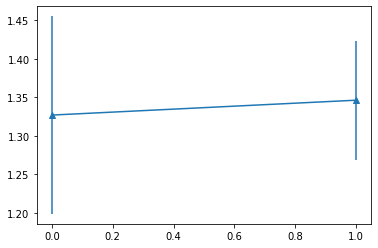

In [36]:
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt
from hyperimpute.plugins.imputers import Imputers

range_ = np.linspace(0, 1, 2)
rmse_mean = []
rmse_std = []
for r_density in range_:
    print(r_density)
    temp = []
    for it in range(10):
        gt, ds = get_miss_dataset(density_R=r_density)
        # kni = KNNImputer(n_neighbors=5)
        hpi = Imputers().get(
            'hyperimpute',
            optimizer='hyperband',
            classifier_seed=['logistic_regression'],
            regression_seed=['linear_regression']
        )
        imp = hpi.fit_transform(ds)
        temp.append(np.sqrt(np.sum(np.square(gt.values - imp.values))/N))
    rmse_mean.append(np.mean(temp))
    rmse_std.append(np.std(temp))

plt.errorbar(range_, rmse_mean, rmse_std, marker='^')
plt.show()